# Neural Population

### Homogeneous populations:
    i) All neurons 1 ≤ i ≤ N are identical.
    ii) All neurons receive the same external input I i ext ( t ) = I ext ( t ) .
    iii) The interaction strength w ij for the connection between any pair (j , i) of pre- and postsynaptic
         neurons is statistically uniform(w ij ~ w 0 ).

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

## Population activity A ( t )
    In a network of N neurons, count the number of spikes n_act( t ; t + ∆ t ) in a small time interval ∆ t.
    
    Connectivity schemes:
    
        1)Full connectivity scheme:
            The all-to-all connectivity within a population.
            All connections have the same strength.
            
        2)Random connectivity(fixed coupling probability):
            Choose connections randomly with probability p among all the possible N^2 connections.
            The number of presynaptic connections C_j to a postsynaptic neuron j has a mean value of h C_i=pN,  
            but differs between one neuron and the next with variance p(1 − p)N.
            
        3)Random connectivity(fixed number of presynaptic partners):
            A fixed connection probability (say 10 % ) cannot be correct in simulations!
            Moreover, not all neurons will be active at the same time, depends on the stimulation conditions
            and the task.
    

In [2]:
def population_activity(I_init, gl, Cm, num, typeofconnect, prob_fixnum):
    ######### Constants
    U_rest      =   -0.065                  # restint membrane potential [U]
    U_reset     =   -0.065
    thresh  =   -0.050                      # spiking threshold [U]
    tau =  Cm/gl
  

    ######### Setup
    # TIME
    T       =   0.100                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    
    # VOLTAGE
    U       =   np.empty((1000,len(time)))    # array for saving Voltage history
    U[:,0]    =   U_rest                     # set initial to resting potential
    
    # CURRENT
    I_init = I_initial(I_init=I_init, time=time,num = num)
    I = np.zeros((1000,len(time)))

    ######### Measurements
    spikes = np.zeros((1000,len(time)))              # counter for number of spikes
    act = []
    W = weights(typeofconnect,prob_fixnum)           #set weights for the connection
    
    ######### Simulation
    for i in range(len(time)):
        for j in range(1000):
            #compute current
            I[j][i]= I_init[i] + I[j][i]
            # use " tau.(du/dt) = -(U(t) -U_rest) + R.I(t))" to get this equation
            U[j][i] = (((U_rest - U[j][i-1]) + I[j][i]/gl)*dt)/tau + U[j][i-1]
                 
            # in case we exceed threshold
            if U[j][i] > thresh:
                U[j][i-1] = 0.04      # set the last step to spike value
                U[j][i] = U_reset     # current step is resting membrane potential
                spikes[j][i] =time[i] # count spike
                act.append([i,j])
                if(i< 4997):
                    add_amount = I_values(j,i,I_init,time,spikes,W)
                    I[:,i+1:i+5] = I[:,i+1:i+5] + add_amount
                
    return act , I_init

#compute the initial current
def I_initial(I_init=0.005, time=None, num = 1):
    I0 = np.zeros(len(time))
    I0[0:4999] = I_init
    I1 = []
    I2 = []

    #Setting the initial current_ I1 
    for i in range(0, len(time)):
        
        var = gauss(I_init,I_init*0.1)
        I1.append(var)
    
    #Setting the initial current_ I2
    for i in range(0, len(time)):
        
        var = ((math.cos(i/100)+1)/4)*((math.sin(i/300)+1)/4)*(gauss(0,0.4*I_init))+I_init
        I2.append(var)
   
    I = [I0,I1,I2]
    return I[num-1]


#compute the effect of presynaptic neuron's spike to their postsynaptic neurons!            
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, W=None ,tau_I=0.001):
    #use w_ji*epsilon(s) where epsilon(s) = (s/tau).exp(1-(s/tau)) ;s=t - t_spike > 0
    exp1= (time[i+1:i+5] - spikes[j][i])/tau_I
    exp2= np.exp(1-exp1)
    exp3= exp1*exp2
    I_inp = np.dot(W[j,:].reshape(1000,1),exp3.reshape(1,4))
    return I_inp


#compute the weights of connectivity due to type of connectivty!
def weights( typeofconnectivity = 'full' , prob_fixnum = 1):
    
    w = np.zeros((1000,1000))
    w[0:800,:] = abs(np.random.normal(6,4,size=(800,1000)))
    w[800:1000,:] = -1*abs(np.random.normal(6,4,size=(200,1000)))
    for i in range(1000): w[i,i]=0
        
    if( typeofconnectivity == 'full'):
        w=w/1000
        return w
    
    if( typeofconnectivity == 'randomprob'):
        A = sparse.random(1000, 1000, density=prob_fixnum, data_rvs=np.ones).toarray()
        w = w*A/(1000*prob_fixnum)
        return w
    
    if( typeofconnectivity == 'randomfix'):
        A = np.zeros((1000,1000))
        for i in range(1000):
            j = np.random.choice(list(range(1000)), prob_fixnum, replace=False)
            A[i][j] = 1
        w = w*A/100
        return w

### Population activity of neurons Simulation (excitatory (80%) and inhibitory (20%) neurons)

In [3]:
def simul_pop(I_init ,gl_init ,Cm_init, num, typeofconnect, prob_fixnum  ):
    act , I= population_activity(I_init, gl_init, Cm_init, num, typeofconnect, prob_fixnum)
    act = np.array(act)
    
    color = np.where(act[:,1]>799,'r','b')
    ###ploting
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("current", figsize=(20, 3))
    plt.title("current")
    plt.plot(np.arange(5001), I)
    plt.ylabel("Potential [V]")
    plt.xlabel("Time [s]")
    
    fig = plt.figure("Population activity of neurons", figsize=(20, 8))
    plt.title("Population activity of neurons")
    plt.scatter(act[:,0],act[:,1],marker='o',c = color , s=2)
    plt.ylabel("Number of neurons")
    plt.xlabel("Time [s]")
    
    
    

### Full connectivity scheme

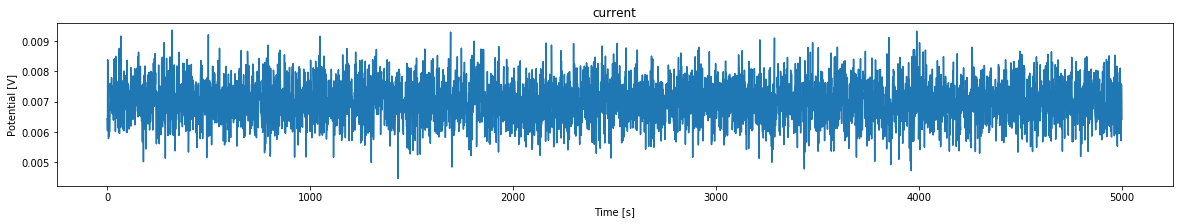

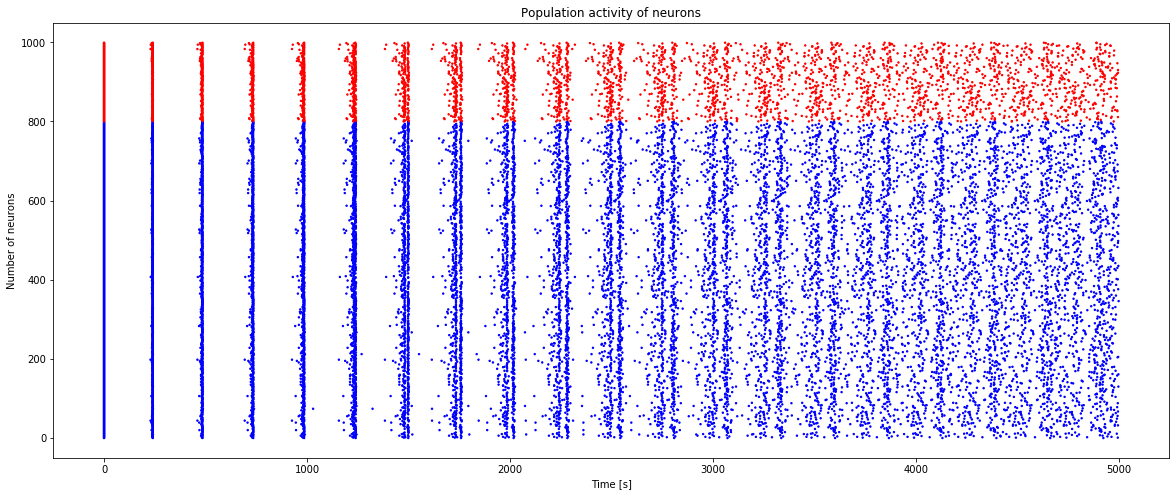

In [4]:
simul_pop(0.007 ,0.016,0.0049 ,2,'full' , 0.35)

### Random connectivity: fixed coupling probability 

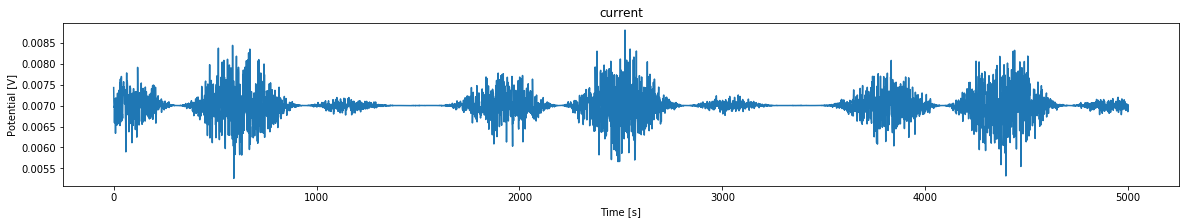

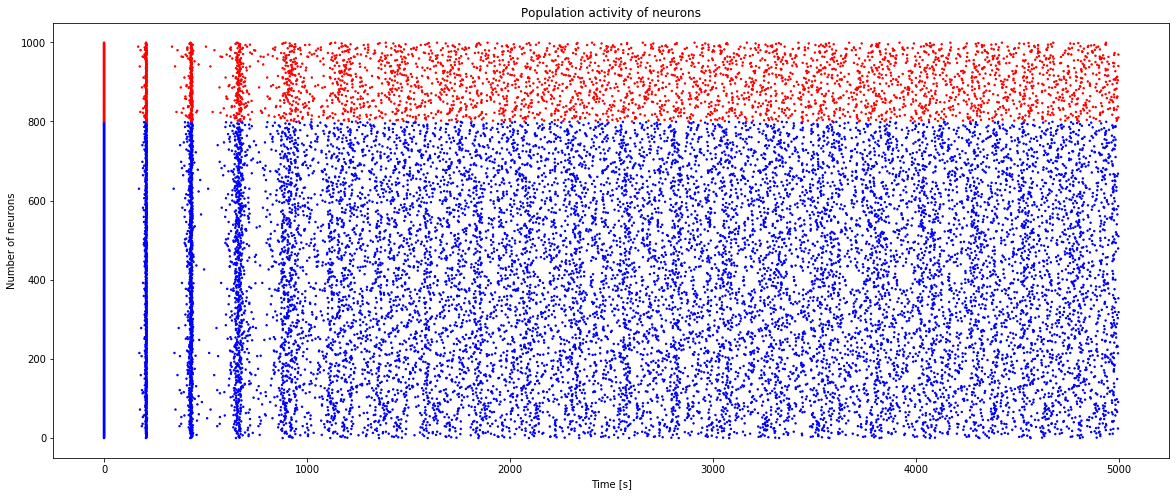

In [5]:
simul_pop(0.007 ,0.016,0.0049 ,3,'randomprob' , 0.25)

### Random connectivity: fixed number of presynaptic partners

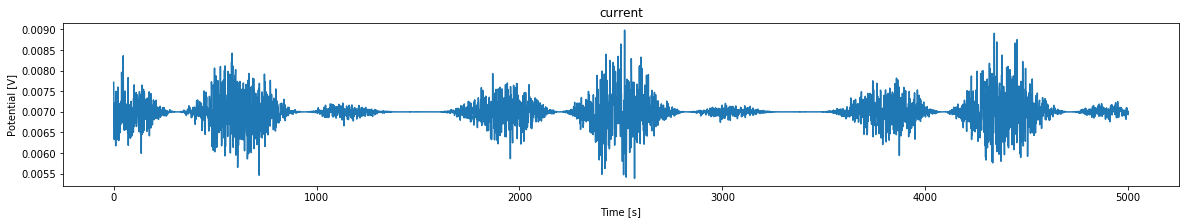

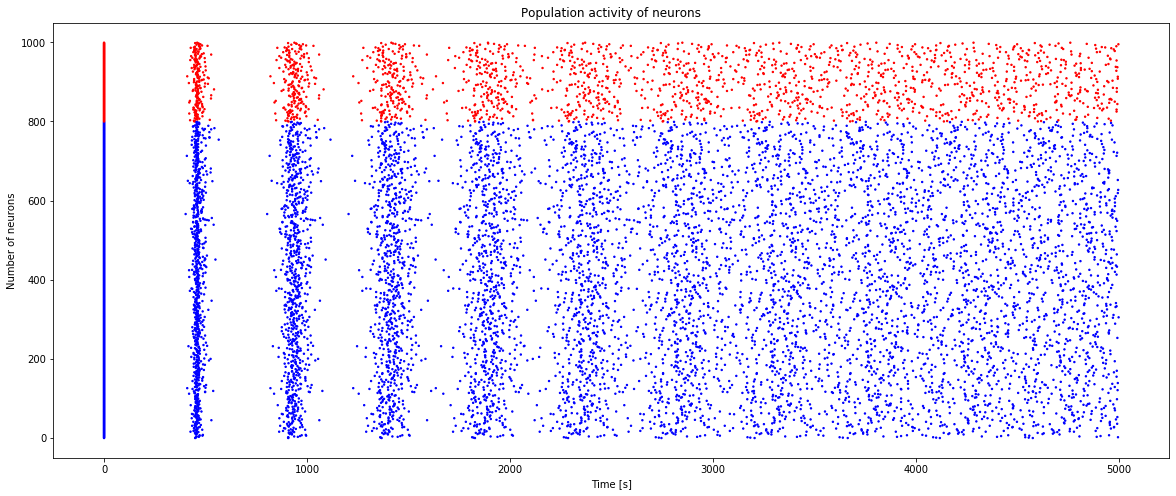

In [6]:
simul_pop(0.007 ,0.016,0.0049 ,3,'randomfix' , 20)

Sharare Zolghadr (610395109)

Computational Neuroscience